In [1]:
import collections
from collections import Counter
import math
import string
import logging
import numpy as np
import pandas as pd
from itertools import permutations
from sympy.utilities.iterables import partitions
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

### Test Variables

In [2]:
prior = [1/2, 1/3, 1/6]
n = 10
k = 3

## Functions

---
**k_dictionary**

Input: pi, the probability distribution

Output: a dictionary with letters for keys. The letters represent individual diseases. Can be used to keep track of individual diseases throughout the gain function calculations.

```python
pi = [1/2, 1/3, 1/6]
k_dict = {'a': 0.5, 'b': 0.33333, 'c':0.166666}
```

In [3]:
def k_dictionary(pi):
    pi.sort(reverse=True)
    return dict(zip(string.ascii_lowercase, pi))

In [34]:
k_dict = k_dictionary(prior)
print(k_dict)

{'a': 0.5, 'b': 0.3333333333333333, 'c': 0.16666666666666666}


---
**gen_col** generates a non-unform random sample of size n according to the prior

In [4]:
def gen_col(n, k, prior):
    return np.random.choice(np.arange(1,k+1), n, p=prior)

In [4]:
a = gen_col(n, k, prior)
print(a)

[1 1 1 2 1 1 2 2 2 1]


---
**col_letter_list** turns nparray of ints to a list of strings.

Uses **letter_dictionary** as helper function

In [5]:
def letter_dictionary():
    return dict(zip(range(1, k+1), string.ascii_lowercase))

In [6]:
letter_dict = letter_dictionary()
print(letter_dict)

{1: 'a', 2: 'b', 3: 'c'}


In [11]:
def col_letter_list(col):
    letter_list = []
    letter_dict = letter_dictionary()
    tuple_col = tuple(col)
    for x in tuple_col:
        letter_list.append(letter_dict[x])
    return letter_list

In [8]:
my_letter_list = col_letter_list(a)
print(my_letter_list)

['a', 'a', 'a', 'b', 'a', 'a', 'b', 'b', 'b', 'a']


**gen_index_list** provides a list of indices to the adversary

In [7]:
def gen_index_list(letter_list):
    ind_x = []
    ind_y = []
    ind_z = []
    index_list = []
    i = 0
    for x in letter_list:
        if x=='a':
            ind_x.append(i)
        elif x == 'b':
            ind_y.append(i)
        elif x == 'c':
            ind_z.append(i)
        else:
            raise Exception("x != a, b, c")
        i = i + 1
    index_list.append(ind_x)
    index_list.append(ind_y)
    index_list.append(ind_z)
    return index_list

In [83]:
index_list = gen_index_list(my_letter_list)
print(index_list)

[[0, 1, 2, 4, 5, 9], [3, 6, 7, 8], []]


In [8]:
def index_list_to_guess(index_list, prior, n):
    guess_list = []
    index_list.sort(key=len, reverse=True)
    d2b = {'a': index_list[0], 'b': index_list[1], 'c': index_list[2]}
    for i in range(n):
        if i in d2b['a']:
            guess_list.append('a')
        elif i in d2b['b']:
            guess_list.append('b')
        elif i in d2b['c']:
            guess_list.append('c')
        else:
            raise Exception("issue generating guess list")
    return guess_list

In [98]:
index_list_to_guess(index_list, prior, n)

['a', 'a', 'a', 'b', 'a', 'a', 'b', 'b', 'b', 'a']

In [12]:
def bayes_test(n, k, prior):
    ## Client has a plaintext column
    col = gen_col(n, k, prior)
    letter_list = col_letter_list(col)
    logging.info("*** Plaintext Column *** -\n {}".format(letter_list))
    ## Generate index partition
    index_list = gen_index_list(letter_list)
    guess_list = index_list_to_guess(index_list, prior, n)
    ## Check if guess is correct
    trust_value = (letter_list == guess_list)
    logging.info("*** True or False? *** -\n {}".format(trust_value))
    return trust_value

In [13]:
bayes_test(n, k, prior)

False

In [16]:
def run_tests(num_tests, n, k, prior):
    yay = 0
    for i in range(num_tests):
        val = bayes_test(n, k, prior)
        if val == True:
            yay = yay + 1
    return yay/num_tests

In [18]:
num_tests = 100
n = 10
k = 3
prior = (1/2, 1/3, 1/6)
success = run_tests(num_tests, n, k, prior)
print("Success rate: ", success)

Success rate:  0.59


In [212]:
logging.getLogger().setLevel(logging.INFO)

In [235]:
logging.getLogger().setLevel(logging.WARNING)

# Bayes Tests

Posterior bayes vulnerability for n = 10: approx .51

1000 experiments: 60.4% success rate

Additional 1000: 62.6% success rate

In [27]:
num_tests = 1000
n = 10
k = 3
prior = (1/2, 1/3, 1/6)

In [28]:
success_rate = run_tests(num_tests, n, k, prior)
print("Your success rate: ", success_rate)

Your success rate:  0.618


In [29]:
success_rate = run_tests(num_tests, n, k, prior)
print("Your success rate: ", success_rate)

Your success rate:  0.626


Posterior bayes vuln for n = 20 is approx 0.66

At 500 tests, we're successfull 73.6%

In [22]:
num_tests = 500
n = 20
k = 3
prior = [1/2, 1/3, 1/6]
success_rate = run_tests(num_tests, n, k, prior)
print("Your success rate: ", success_rate)

Your success rate:  0.736


## C/P Bayes Functions

In [23]:
from sympy.utilities.iterables import partitions
from sympy.functions.combinatorial.numbers import stirling

In [24]:
def calc_set_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    frac = num / den
    return frac

In [25]:
def calc_max_prob(p, Pi):
    Pi.sort(reverse=True)
    frac = 1
    ind = 0
    val = -1
    for key in sorted(p.keys(), reverse=True):
        val = p[key]
        for i in range(val):
            frac = frac * pow(Pi[ind], key)
            ind = ind + 1
    return frac

In [26]:
def nonuni_post_bayes_vuln(n, k, Pi):
    pbvsum = 0
    for p in partitions(n, m=k):  
        num = calc_set_partitions(n,p)
        frac = calc_max_prob(p, Pi)
        val = num * frac
        pbvsum = pbvsum + val
    return pbvsum

## Comparing Bayes Posterior Vuln and Experimental Success

In [346]:
def bayes_post_vs_success(n_range, k, probs, num_tests):
    post_bayes_vs = []
    success = []
    for i in range(n_range):
        post_bayes_vs.append(nonuni_post_bayes_vuln(i+1, k, probs))
        success.append(run_tests(num_tests, i+1, k, probs))
    df = pd.DataFrame(
        {'posterior':post_bayes_vs,
         'success':success
        }
    )
    return df

In [359]:
def graph_bayes_exp(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    plt.plot(x, 'posterior', data=df, label="posterior")
    plt.plot(x, 'success', data=df, label="success")
    plt.xlabel("n values")
    plt.ylim(bottom = -.1, top = 1)
    plt.legend()
    plt.show()
    plt.close()

### n = 1 - 100, 100 tests per n

In [361]:
n_range = 100
k = 3
probs = [1/2, 1/3, 1/6]
num_tests = 100

In [362]:
df_vs = bayes_post_vs_success(n_range, k, probs, num_tests)
df_vs

,posterior,success
0,0.5000000000,0.47
1,0.4166666667,0.60
2,0.4027777778,0.55
3,0.3958333333,0.60
4,0.4131944444,0.53
5,0.4311342593,0.59
6,0.4507137346,0.51
7,0.4712416409,0.56
8,0.4918954690,0.65
9,0.5100027328,0.69


In [367]:
df_vs.to_csv (r'data\df_vs_100_nonuni.csv', index = None, header=True) 

In [ ]:
df_vs100_csv = pd.read_csv('data\df_vs_100_nonuni.csv')

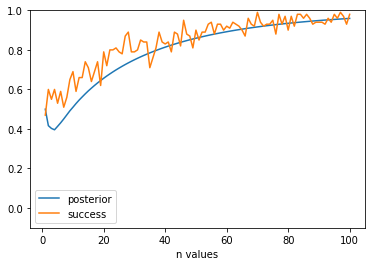

In [363]:
graph_bayes_exp(n_range, k, probs, df_vs)

## n = 1 - 200, 200 tests per n

Approx. 13 minutes to run

In [364]:
n_range = 200
k = 3
probs = [1/2, 1/3, 1/6]
num_tests = 200

In [365]:
df_200 = bayes_post_vs_success(n_range, k, probs, num_tests)
df_200

,posterior,success
0,0.5000000000,0.435
1,0.4166666667,0.585
2,0.4027777778,0.510
3,0.3958333333,0.540
4,0.4131944444,0.545
5,0.4311342593,0.620
6,0.4507137346,0.535
7,0.4712416409,0.590
8,0.4918954690,0.695
9,0.5100027328,0.615


In [369]:
df_200.to_csv (r'data\df_200_nonuni.csv', index = None, header=True) 

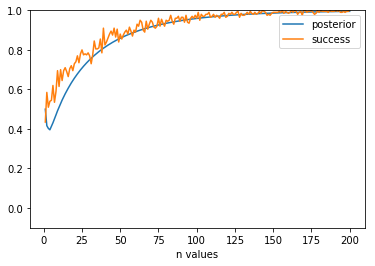

In [366]:
graph_bayes_exp(n_range, k, probs, df_200)